In [1]:
! pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 20.0 MB/s eta 0:00:00


In [2]:
import sys
import pandas as pd
import numpy as np
import matplotlib as plt
import statistics
import os
import torch
from torch.utils.data import Dataset, TensorDataset
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import optuna
import pickle

In [3]:
# to load custom libraries
sys.path.append("drive/MyDrive/KeepCoding/DeepLearning/exercise")

# path to data and libraries
data_path = "drive/MyDrive/KeepCoding/DeepLearning/exercise"
from utilsMAP import *

# load dataset
poi_data = pd.read_csv(os.path.join(data_path, "poi_dataset.csv"))

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Cargamos el dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

batch_size = 64

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Dividimos los datos
train_size = int(0.85 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = random_split(trainset, [train_size, val_size])


# Calculamos la media y desviación estándar del conjunto de entrenamiento
train_data = np.array([img.numpy() for img, _ in trainset])
mean = train_data.mean() # Normalizamos a [0, 1]: Los datos ya están en ese rango
std = train_data.std()

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean] * 3, std=[std] * 3)
])

# Aplicamos las transformaciones a los conjuntos de datos
#trainset.dataset.transform = transform_train
#valset.dataset.transform = transform_test
#testset.transform = transform_test

# Recreamos los dataloaders
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

# Imprimir tamaños de los datasets
print(f"Tamaño del conjunto de entrenamiento: {len(trainset)}")
print(f"Tamaño del conjunto de validación: {len(valset)}")
print(f"Tamaño del conjunto de test: {len(testset)}")

100%|██████████| 170M/170M [00:03<00:00, 47.3MB/s]


Tamaño del conjunto de entrenamiento: 42500
Tamaño del conjunto de validación: 7500
Tamaño del conjunto de test: 10000


In [13]:
for e in trainset:
  print(e[0])
  #print(e[0].shape)
  print(e[1])
  break
#for e in train_loader:
#  #print(e[0])
#  print(e[0].shape)
#  print(e[1])
#  break

tensor([[[0.4824, 0.4667, 0.4510,  ..., 0.4157, 0.3843, 0.3804],
         [0.4706, 0.4706, 0.5255,  ..., 0.4275, 0.3843, 0.3882],
         [0.4549, 0.4314, 0.5216,  ..., 0.4196, 0.4196, 0.4078],
         ...,
         [0.4745, 0.4314, 0.4000,  ..., 0.4510, 0.4039, 0.4353],
         [0.4471, 0.4196, 0.3608,  ..., 0.4118, 0.4353, 0.4627],
         [0.4353, 0.4078, 0.3961,  ..., 0.3961, 0.4510, 0.4824]],

        [[0.5608, 0.5294, 0.4431,  ..., 0.4824, 0.4510, 0.4706],
         [0.5843, 0.5333, 0.4980,  ..., 0.4902, 0.4667, 0.4863],
         [0.5961, 0.5098, 0.4980,  ..., 0.4941, 0.5137, 0.5098],
         ...,
         [0.5412, 0.4902, 0.4078,  ..., 0.4824, 0.4745, 0.5373],
         [0.5176, 0.4627, 0.3647,  ..., 0.4392, 0.5176, 0.5843],
         [0.5098, 0.4353, 0.4157,  ..., 0.3725, 0.4706, 0.5804]],

        [[0.2667, 0.2588, 0.2627,  ..., 0.2706, 0.2392, 0.2510],
         [0.2627, 0.2706, 0.2902,  ..., 0.2471, 0.2157, 0.2275],
         [0.2745, 0.2588, 0.3059,  ..., 0.2431, 0.2588, 0.

In [5]:
# Hyperparameters
num_epochs = 5 # ???
batch_size = 128 # ???
learning_rate = 0.01 # ???
l2_lambda = 1e-4 # ???
l1_lambda = 1e-4 # ???
step_size = 2 # ???
gamma = 0.1 # ???
dropout_rate = 0.2 # ???
act_funct = nn.ReLU() # ????
#number_layers = 2 # 1, 2, 3, 4, 5
#layer_size = 32 # ???

In [6]:
# Define CNN
class CNN(nn.Module):
    def __init__(self, dropout_rate, act_funct):
        super(CNN, self).__init__()

        # First convolutional layer
        self.convLayer1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding = 1),
            nn.BatchNorm2d(32),
            act_funct,
            nn.MaxPool2d(2,2),
            nn.Dropout(dropout_rate)
        )

        # Second convolutional layer
        self.convLayer2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding = 1),
            nn.BatchNorm2d(64),
            act_funct,
            nn.MaxPool2d(2,2),
            nn.Dropout(dropout_rate)
        )

        # Third convolutional layer
        self.convLayer3 = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding = 1),
            nn.BatchNorm2d(64),
            act_funct,
            nn.MaxPool2d(2,2),
            nn.Dropout(dropout_rate)
        )
        # Fully connected layer (classificator)
        self.fcLayer1 = nn.Sequential(
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            act_funct,
            nn.Dropout(dropout_rate),
            nn.Linear(64, 10)
        )

        # Set global pooling (max/avg)
        self.global_max_pool = nn.AdaptiveMaxPool2d(1) # torch.nn.AdaptiveMaxPool2d(output_size,...)
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        x = self.convLayer1(x)
        x = self.convLayer2(x)
        x = self.convLayer3(x)
        max_pooled = self.global_max_pool(x).squeeze()
        avg_pooled = self.global_avg_pool(x).squeeze()
        x = torch.cat((max_pooled, avg_pooled), dim=1)
        x = self.fcLayer1(x)
        return x

Device: cuda:0
Epoch 1, Loss: 1.9664174264534973, Acc: 43.256470588235295, Val Loss: 2.5923143362594865, Val Acc: 22.293333333333333, LR: 0.01
Epoch 2, Loss: 1.8396469524928503, Acc: 50.82588235294118, Val Loss: 1.3551248746403193, Val Acc: 51.21333333333333, LR: 0.001
Epoch 3, Loss: 1.5678809787994041, Acc: 58.97882352941176, Val Loss: 1.5023671913955172, Val Acc: 46.86666666666667, LR: 0.001
Epoch 4, Loss: 1.4525578287311067, Acc: 61.063529411764705, Val Loss: 1.2889706103478449, Val Acc: 54.6, LR: 0.0001
Epoch 5, Loss: 1.389787317218637, Acc: 62.80235294117647, Val Loss: 1.3138102060657437, Val Acc: 53.306666666666665, LR: 0.0001


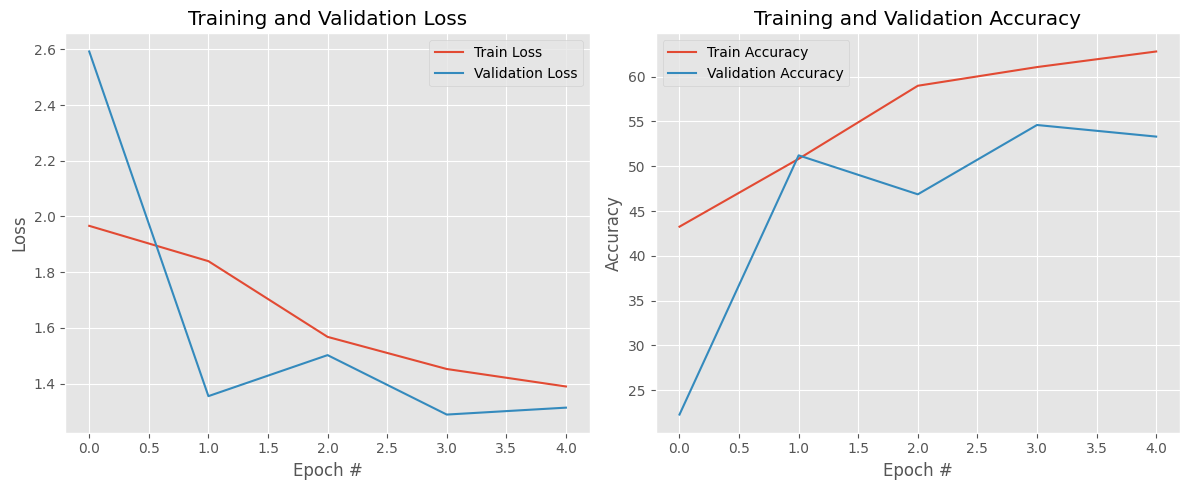

In [7]:
# train model
model = CNN(dropout_rate, act_funct)
#train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')
train_model(model, criterion, optimizer, num_epochs, train_loader, val_loader,
            device, l1_lambda=l1_lambda, scheduler = scheduler)


In [8]:
def objective(trial):
    """
    Función objetivo para la optimización de hiperparámetros con Optuna.
    """

    # Generamos una semilla para reproducibilidad
    #trial_seed = random.randint(1, 200)
    #trial.set_user_attr("seed", trial_seed)
    #print(f"\n🎲 Usando semilla: {trial_seed}")

    # Fijamos la semilla
    #set_random_seed(trial_seed)
    set_random_seed()

    # Definimos los hiperparámetros a optimizar
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True)
    l2_lambda = trial.suggest_float("l2_lambda", 1e-4, 1e-1, log =True)
    l1_lambda = trial.suggest_float("l1_lambda", 1e-4, 1e-1, log =True)
    step_size = trial.suggest_int("step_size", 1, 3)
    gamma = trial.suggest_float("gamma", 1e-4, 1e-1, log =True)
    act_funct = trial.suggest_categorical("act_funct",["ReLU", "LeakyReLU", "Sigmoid"])

    if act_funct == "ReLU":
      funct = nn.ReLU()
    elif act_funct == "LeakyReLU":
      funct = nn.LeakyReLU()
    elif act_funct == "Sigmoid":
      funct = nn.Sigmoid()

#    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Creamos el modelo y lo movemos al dispositivo
    model = CNN(dropout_rate, funct).to(device)

    # Definimos el optimizador y la función de pérdida
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    criterion = nn.CrossEntropyLoss()

    # Inicializamos listas para almacenar las métricas
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    # Entrenamos por 5 épocas
    for epoch in range(5):
        train_loss, train_acc, _ = train_epoch(model, device, train_loader, criterion, optimizer,
                                            l1_lambda = l1_lambda, scheduler = scheduler)
        val_loss, val_acc = eval_epoch(model, device, val_loader, criterion)

        # Guardamos las métricas de entrenamiento y validación
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

    # Guardamos las métricas en un archivo
    output_metrics_file = os.path.join(data_path,"CNN",f"metrics_{trial.number}.pkl")
    with open(output_metrics_file, "wb") as f:
        pickle.dump({"train_losses": train_losses,
                     "train_accs": train_accs,
                    "val_losses": val_losses,
                    "val_accs": val_accs}, f)

    # Guardamos el path de las métricas como parámetro de usuario
    trial.set_user_attr("metrics_path", output_metrics_file)

    return val_accs[-1]

In [9]:
# Creamos un estudio de optuna
# Eliminamos el estudio si existe
try:
    optuna.delete_study(study_name="cnn_optimization", storage=os.path.join("sqlite:///",data_path,"CNN","cnn_study.sqlite3"))
except:
    pass

study = optuna.create_study(study_name="cnn_optimization", direction="maximize",
                            storage=os.path.join("sqlite:///",data_path,"CNN","cnn_study.sqlite3"),
                            sampler=optuna.samplers.TPESampler())

# Optimizamos con 81 trials (todo el espacio de búsqueda)
n_trials = 32

AttributeError: module 'sqlalchemy.sql' has no attribute 'base'

In [ ]:
study.optimize(objective, n_trials=n_trials)